# 04 – LSTM Model for Phishing Email Detection

In this notebook we:
- load the preprocessed dataset (`cleaned.csv`)
- tokenize and pad the email texts
- build a simple LSTM-based classifier
- train the model and evaluate it on a test set
- compare later with the Naive Bayes baseline

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

DATA_PATH = Path("../data/processed/cleaned.csv")
df = pd.read_csv(DATA_PATH)

# Safety: make sure text has no NaNs
df['clean_body'] = df['clean_body'].fillna('').astype(str)

df.head()

,clean_body,label
0,buck up your troubles caused by small dimensio...,1
1,upgrade your sex and pleasures with these tech...,1
2,the daily top from cnncom top videos and stori...,1
3,would anyone object to removing so from this l...,0
4,welcomefastshippingcustomersupport,1


In [2]:
X = df['clean_body']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train), len(X_test)

(31323, 7831)

In [3]:
MAX_WORDS = 10000    # size of vocabulary
MAX_LEN = 300        # max number of tokens per email

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

# Pad / truncate sequences to fixed length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post', truncating='post')

X_train_pad.shape, X_test_pad.shape

((31323, 300), (7831, 300))

In [4]:
EMBED_DIM = 64
LSTM_UNITS = 64

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM),
    LSTM(LSTM_UNITS),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
EPOCHS = 5
BATCH_SIZE = 64

history = model.fit(
    X_train_pad, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1
)

Epoch 1/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - accuracy: 0.6753 - loss: 0.6018 - val_accuracy: 0.6728 - val_loss: 0.5953
Epoch 2/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.8647 - loss: 0.3107 - val_accuracy: 0.9726 - val_loss: 0.1321
Epoch 3/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.9711 - loss: 0.1226 - val_accuracy: 0.9505 - val_loss: 0.1679
Epoch 4/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9774 - loss: 0.1017 - val_accuracy: 0.9853 - val_loss: 0.0655
Epoch 5/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.9891 - loss: 0.0555 - val_accuracy: 0.9898 - val_loss: 0.0471


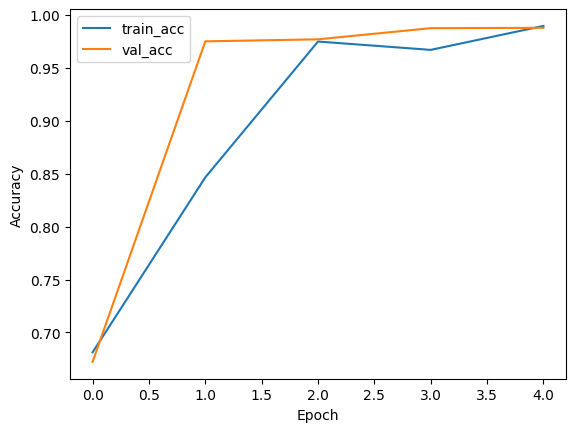

In [7]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
y_probs = model.predict(X_test_pad).ravel()
y_pred = (y_probs >= 0.5).astype(int)

print(classification_report(y_test, y_pred))

245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3462
           1       0.99      0.99      0.99      4369

    accuracy                           0.99      7831
   macro avg       0.99      0.99      0.99      7831
weighted avg       0.99      0.99      0.99      7831



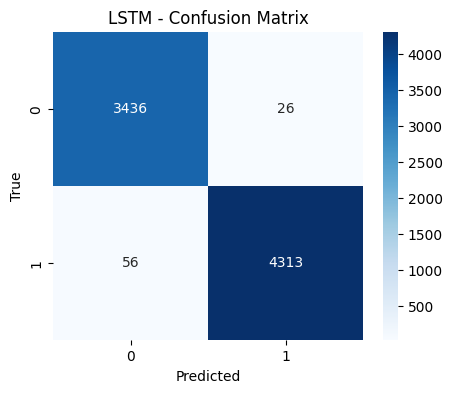

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("LSTM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [10]:
models_path = Path("../models")
models_path.mkdir(exist_ok=True)

model.save(models_path / "lstm.h5")

In [11]:
from io import StringIO

report_str = classification_report(y_test, y_pred)

results_path = Path("../results")
results_path.mkdir(exist_ok=True)

with open(results_path / "lstm_report.txt", "w", encoding="utf-8") as f:
    f.write(report_str)